In [ ]:
#pytorch CV
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download = True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16255385.13it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269171.97it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5097311.99it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5901141.57it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# first sample
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [ ]:
class_names = train_data.classes

class_to_idx_mapping = train_data.class_to_idx
class_to_idx_mapping

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

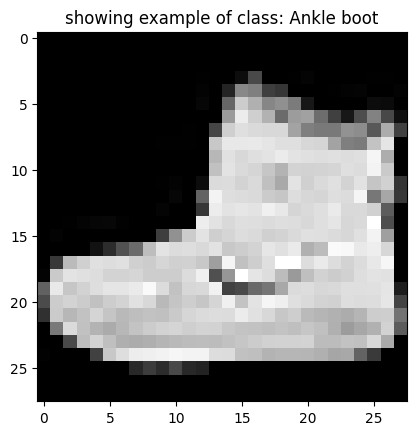

In [ ]:
# ploting the image to visualize
def plot_image(img, label, color=None):
  img = img.squeeze()
  plt.imshow(img, cmap=color)
  plt.title(f"showing example of class: {class_names[label]}")

img, label = train_data[0]
plot_image(img, label, 'gray')

In [ ]:

from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

In [ ]:
print(f"length of train_dataloader: {len(train_dataloader)}, of size {BATCH_SIZE} each")
print(f"length of test_dataloader: {len(test_dataloader)}, of size {BATCH_SIZE} each")

# each batch will have dimensions [32, 1, 28, 28]
# if needed we can augment data
# build transformation pipeline to transform any input image to pre-defined structure.


length of train_dataloader: 1875, of size 32 each
length of test_dataloader: 313, of size 32 each


In [ ]:
# modelling
from torchvision import models

class CustomResNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    self.resnet = models.resnet18(pretrained=True)

    for param in self.resnet.parameters():
      param.requires_grad = False

    self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.num_filters = self.resnet.fc.in_features
    self.resnet.fc = nn.Sequential(
        nn.Linear(self.num_filters, 512),
        nn.ReLU(),
        nn.Linear(self.num_filters, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_names))
    )

  def forward(self, x):
    return self.resnet(x)

model = CustomResNet(len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, Trainable: {param.requires_grad}")


In [ ]:
from torchsummary import summary
# load pretrained res
summary(model, input_size=(1, 28, 28))


In [ ]:
def accuracy_calculation(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# dummy_x = torch.rand([2,1,28,28])
# resnet(dummy_x)

In [ ]:
# building training loop
torch.manual_seed(42)
epochs = 20
epoch_count = []
training_loss_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
  print(f"Epoch count: {epoch}")
  training_loss = 0
  avg_training_acc = 0
  model.train()
  for idx, batch in enumerate(train_dataloader):
    imgs, label = batch
    imgs = imgs.to(device)
    label = label.to(device)
    optimizer.zero_grad()

    y_pred = model(imgs)
    loss = loss_fn(y_pred, label)

    loss.backward()
    optimizer.step()

    training_loss += loss
    training_acc = accuracy_calculation(y_pred.argmax(dim=1), label)
    avg_training_acc += training_acc
    if idx%500 == 0 and idx>0:
      print(f"{idx} number of batch processed and current training_loss is {training_loss/idx}, and training acc: {training_acc}")

  training_loss = training_loss/len(train_dataloader)
  avg_training_acc /= len(train_dataloader)


  # eval
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for idx, batch in enumerate(test_dataloader):
      imgs, test_label = batch
      imgs = imgs.to(device)
      test_label = test_label.to(device)

      test_pred = model(imgs)
      t_loss = loss_fn(test_pred, test_label)
      test_loss += t_loss

      t_acc = accuracy_calculation(test_pred.argmax(dim=1), test_label)
      test_acc += t_acc

    test_loss = test_loss/len(test_dataloader)
    test_acc = test_acc/len(test_dataloader)

  print(f"Epoch: {epoch} || training_loss: {training_loss}, training acc: {training_acc} || test_loss: {test_loss}, test_acc: {test_acc}")
  epoch_count.append(epoch)
  training_loss_list.append(training_loss)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)




Epoch count: 0
500 number of batch processed and current training_loss is 1.539985179901123, and training acc: 59.375
1000 number of batch processed and current training_loss is 1.3737337589263916, and training acc: 65.625
1500 number of batch processed and current training_loss is 1.3004192113876343, and training acc: 59.375
Epoch: 0 || training_loss: 1.2654662132263184, training acc: 65.625 || test_loss: 1.1178301572799683, test_acc: 59.165335463258785
Epoch count: 1
500 number of batch processed and current training_loss is 1.1065926551818848, and training acc: 59.375
1000 number of batch processed and current training_loss is 1.0995140075683594, and training acc: 56.25
1500 number of batch processed and current training_loss is 1.0925726890563965, and training acc: 56.25
Epoch: 1 || training_loss: 1.0858745574951172, training acc: 40.625 || test_loss: 1.0774492025375366, test_acc: 60.90255591054313
Epoch count: 2
500 number of batch processed and current training_loss is 1.05564963

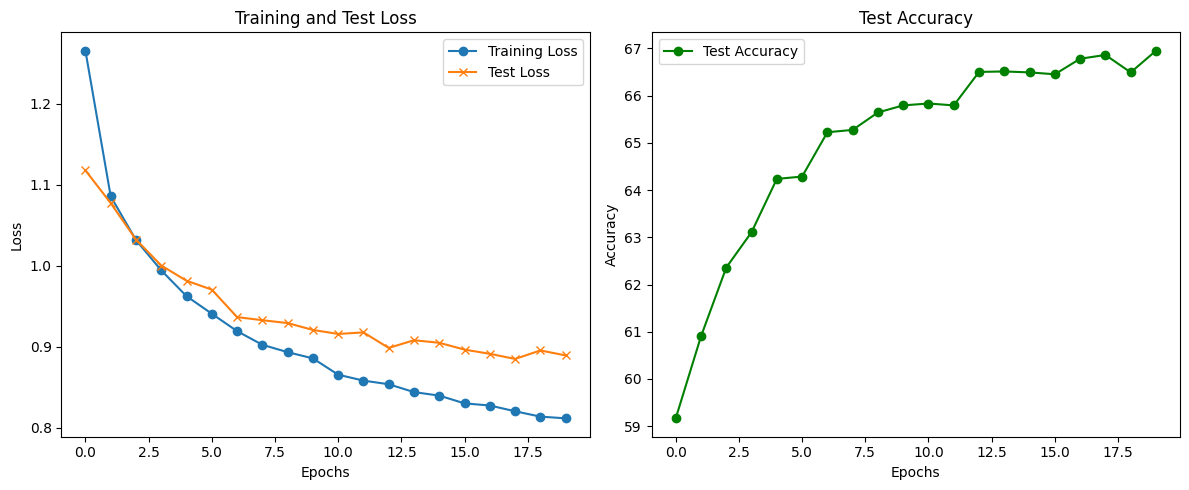

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epoch_count, [tensor.detach().cpu().numpy() for tensor in training_loss_list] , label='Training Loss', marker='o')
plt.plot(epoch_count, [tensor.detach().cpu().numpy() for tensor in test_loss_list], label='Test Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_count, test_acc_list, label='Test Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def inference_pipeline(image_path, model):
    preprocess = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path).convert('L')

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0).to(device)  # Adding batch dimension

    # img = input_tensor
    # plot_image(img, 0, 'gray')


    model.eval()
    with torch.inference_mode():
        output = model(input_batch)

    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()




In [ ]:
image_path = "dress.jpeg"

predicted_class = inference_pipeline(image_path, model)
print("Predicted class:", class_names[predicted_class])

Predicted class: Dress


# references
https://pytorch.org/vision/0.9/models.html